In [1]:
import pandas as pd
import torchaudio
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pipetorch.train import *
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import math
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import WeightedRandomSampler

using gpu 3


In [2]:
df = pd.read_csv('../nourish/res/dataset_tensors_melspec/train/audio_train_augmented_melspec_tensors.csv')
df

,filename,modification,label
0,-4wthmfwlwQ_260.pt,None,chewing
1,-5IpgOv9HD0_30.pt,None,chewing
2,-KO1p22zjVc_470.pt,None,chewing
3,-t-lmWNCXt0_10.pt,None,chewing
4,-t95P0R9Pf0_60.pt,None,chewing
...,...,...,...
7827,4gBf0FWwKnQ_100_squeezed.pt,squeezed,other
7828,4gBf0FWwKnQ_100_extended.pt,extended,other
7829,4gBf0FWwKnQ_100_shiftRight.pt,shiftRight,other
7830,4gBf0FWwKnQ_100_shiftLeft.pt,shiftLeft,other


In [3]:
class AudioSet(Dataset):
    def __init__(self, df, root_dir, in_col, out_col, length_sec, sampling_rate):
        self.df = df
        self.root_dir = root_dir
        self.in_col = in_col
        self.out_col = out_col
        self.length_sec = length_sec
        self.sampling_rate = sampling_rate
        
        self.c2i = {'chewing': 0, 'drinking': 1, 'other': 1}
        self.i2c = {0: 'chewing', 1: 'other'}
        
    def __getitem__(self, index):
        filepath = self.root_dir + self.df.iloc[index][self.in_col]
        data = torch.load(filepath)
        label = self.c2i[self.df.iloc[index][self.out_col]]
        return data.cuda(), label
        
    def __len__(self):
        return len(self.df)

In [4]:
def my_precision_score(true_y, pred_y):
    return precision_score(true_y, pred_y, average=None)

In [5]:
def my_recall_score(true_y, pred_y):
    return recall_score(true_y, pred_y, average=None)

In [6]:
def sort_epochs(results, by):
    results = results[results['phase'] != '']
    results[['prec_chewing', 'prec_other']] = pd.DataFrame(results['my_precision_score'].tolist(), index=results.index)
    results[['recall_chewing', 'recall_other']] = pd.DataFrame(results['my_recall_score'].tolist(), index=results.index)

    results = results[results['phase'] == 'valid']
    results = results.sort_values(by, ascending=False)
    print(results[['accuracy_score', 'epoch', 'prec_chewing', 'recall_chewing', 'recall_other']])

In [7]:

# thanks to https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
# modified the function a little to fit our needs

def make_confusion_matrix(true_y,
                          pred_y,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''
    
    cf = confusion_matrix(true_y, pred_y)
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [round(value / np.sum(cf[i // 3]) * 100, 2) for i, value in enumerate(cf.flatten())]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}%".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))


        #Metrics for Binary Confusion Matrices
        precision = precision_score(true_y, pred_y, average=None)
        
        stats_text = "\n\nAccuracy={:0.3f}\nPrecision Chewing={:0.3f}\n Precision other={:0.3f}\n".format(
            accuracy, precision[0], precision[1])
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
    
    group_percentages = np.reshape(group_percentages, (2, 2))

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(
        group_percentages,annot=box_labels,
        fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,
        yticklabels=categories, vmin=0, vmax=100)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [8]:
c2i = {'chewing': 0, 'drinking': 1, 'other': 1}

def predict_test_set(model, df_test, audio_dir, print_wrong=True, gpu=True):
    model = model.cuda() if gpu else model.cpu()
    
    # get labels and filenames
    true_y = [c2i[label] for label in df_test['label'].values]
    filenames = df_test['filename'].values
    pred_y = []
    
    for filename in filenames:
        t = torch.load(audio_dir + filename)
        t = t.cuda() if gpu else t.cpu()
        t = t[None, :] # expand the tensor
        
        with torch.no_grad():
            pred = model(t)
            pred = model.post_forward(pred)
            pred_y.append(pred.data.cpu().numpy()[0])
    # plot conf matrix
    make_confusion_matrix(true_y, pred_y)
    plt.show()
    
    if print_wrong:
        # get false negatives and false positives of eating and drinking
        fn_eating_ind = []
        fn_drinking_ind = []
        fp_eating_ind = []
        fp_drinking_ind = []
        for i, y in enumerate(zip(true_y, pred_y)):
            if(y[0] != y[1]):
                # fn eating
                if y[0] == 0:
                    fn_eating_ind.append(i)
                
                # fn drinking
                if y[0] == 1:
                    fn_drinking_ind.append(i)
                
                # fp eating
                if y[1] == 0:
                    fp_eating_ind.append(i)
            
                # fp drinking
                if y[1] == 1:
                    fp_drinking_ind.append(i)
                
        fn_eating_filenames = [filenames[i] for i in fn_eating_ind]
        fn_drinking_filenames = [filenames[i] for i in fn_drinking_ind]
        fp_eating_filenames = [filenames[i] for i in fp_eating_ind]
        fp_drinking_filenames = [filenames[i] for i in fp_drinking_ind]
    
        # print it
        print('FALSE NEGATIVES EATING:', end='\n\t')
        print('\n\t'.join(fn_eating_filenames))
        print('FALSE NEGATIVES DRINKING:', end='\n\t')
        print('\n\t'.join(fn_drinking_filenames))
        print('FALSE POSITIVES EATING:', end='\n\t')
        print('\n\t'.join(fp_eating_filenames))
        print('FALSE POSITIVES DRINKING:', end='\n\t')
        print('\n\t'.join(fp_drinking_filenames))

In [9]:
df_pos = df[df['label']=='chewing']
df_neg = df.drop(df_pos.index)
bdf_neg = df_neg.sample(n=len(df_pos.index))
bdf = pd.concat([df_pos, bdf_neg])

In [10]:
df_valid = bdf.sample(n=int((len(bdf.index))/5))
df_train = bdf.drop(df_valid.index)
df_test = pd.read_csv('../nourish/res/dataset_tensors_melspec/test/audio_test_melspec_tensors.csv')
# shuffling the sets
df_valid = df_valid.sample(frac=1)
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)
df_train

,filename,modification,label
211,P5y8KlYECM4_290.pt,None,chewing
3667,drinks_10_36_pitched_up.pt,pitched_up,drinking
3358,N52056bH2TA_10_background_sound.pt,background_sound,chewing
7256,-knTMfWlZ98_0_shiftLeft.pt,shiftLeft,other
6572,-Hx1kSTUxHw_30_pitched_up.pt,pitched_up,other
...,...,...,...
3076,GxH0YDJNaxw_30_shiftRight.pt,shiftRight,chewing
3335,Mg7rR5BF1Ko_110_shiftRight.pt,shiftRight,chewing
3230,LaTn5CivQ6Q_0_shiftRight.pt,shiftRight,chewing
4981,drinks_6_26_shiftLeft.pt,shiftLeft,drinking


In [11]:
batch_size = 64

root_dir_train = '../nourish/res/dataset_tensors_melspec/train/audio/'
root_dir_test = '../nourish/res/dataset_tensors_melspec/test/audio/'
train_data = AudioSet(df_train, root_dir_train, 'filename', 'label', 10, 16000)
valid_data = AudioSet(df_valid, root_dir_train, 'filename', 'label', 10, 16000)
test_data = AudioSet(df_test, root_dir_test, 'filename', 'label', 10, 16000)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__(), shuffle=True)

lr = 0.001
epochs = 100

metrics = [accuracy_score, my_precision_score, my_recall_score]

# 1 conv 1 lin

In [83]:
class cnn1Layer1(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(self.out_channels*16*100 , 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = X.reshape(-1, self.out_channels*16*100)
        X = self.w1(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [84]:
cnn1_model = cnn1Layer(4)
cnn1_trainer = trainer(cnn1_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn1_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/345600 [00:00<?, ?it/s]

  1 2.05s trainloss=33.50794 validloss=17.00188 accuracy_score=0.60767 
  2 2.04s trainloss=5.14019 validloss=10.76808 accuracy_score=0.77139 
  3 2.07s trainloss=2.42669 validloss=11.70253 accuracy_score=0.80383 
  4 2.03s trainloss=1.81201 validloss=10.41835 accuracy_score=0.80531 
  5 2.01s trainloss=1.32615 validloss=11.57085 accuracy_score=0.81268 
  6 1.99s trainloss=2.16922 validloss=13.12274 accuracy_score=0.80088 
  7 2.00s trainloss=1.90323 validloss=12.56024 accuracy_score=0.78319 
  8 1.97s trainloss=1.02660 validloss=11.16847 accuracy_score=0.82006 
  9 1.94s trainloss=1.17477 validloss=17.84761 accuracy_score=0.82301 
 10 1.97s trainloss=1.27941 validloss=14.92965 accuracy_score=0.84513 
 11 1.99s trainloss=0.89039 validloss=16.21834 accuracy_score=0.84513 
 12 1.98s trainloss=1.78529 validloss=14.42469 accuracy_score=0.84808 
 13 1.98s trainloss=0.75491 validloss=15.17333 accuracy_score=0.84513 
 14 1.98s trainloss=0.63473 validloss=13.57261 accuracy_score=0.85103 
 15 1

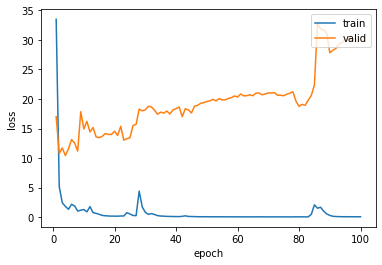

In [85]:
cnn1_trainer.learning_curve()

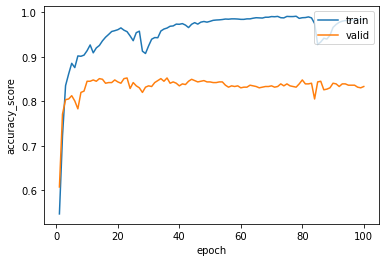

In [86]:
cnn1_trainer.learning_curve(y='accuracy_score')

In [87]:
sort_epochs(cnn1_trainer.evaluator, 'accuracy_score')

    accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
71        0.852507   36.0      0.826923        0.848684      0.855615
45        0.852507   23.0      0.846939        0.819079      0.879679
67        0.851032   34.0      0.828479        0.842105      0.858289
43        0.851032   22.0      0.837209        0.828947      0.868984
27        0.851032   14.0      0.846416        0.815789      0.879679
..             ...    ...           ...             ...           ...
5         0.803835    3.0      0.840637        0.694079      0.893048
11        0.800885    6.0      0.786441        0.763158      0.831551
13        0.783186    7.0      0.794007        0.697368      0.852941
3         0.771386    2.0      0.796813        0.657895      0.863636
1         0.607670    1.0      0.617284        0.328947      0.834225

[100 rows x 5 columns]


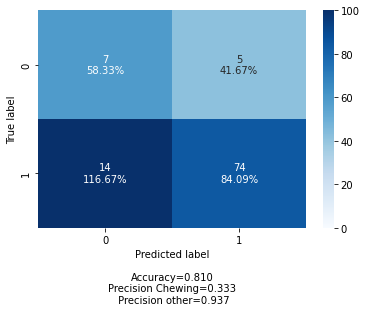

In [88]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn1_model = cnn1_model.cuda()

with torch.no_grad():
        pred_y = cnn1_model(test_X)
        pred_y = cnn1_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# 1 conv 2 lin

In [89]:
class cnn1Layer2(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(self.out_channels*16*100 , 100)
        self.w2 = nn.Linear(100, 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = X.reshape(-1, self.out_channels*16*100)
        X = self.w1(X)
        X = self.w2(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [90]:
cnn1_2_model = cnn1Layer2(4)
cnn1_2_trainer = trainer(cnn1_2_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn1_2_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/345600 [00:00<?, ?it/s]

  1 2.67s trainloss=420.61165 validloss=83.02851 accuracy_score=0.60767 
  2 2.66s trainloss=36.76535 validloss=29.59259 accuracy_score=0.66667 
  3 2.65s trainloss=10.82640 validloss=22.61669 accuracy_score=0.67847 
  4 2.64s trainloss=9.80005 validloss=29.90230 accuracy_score=0.73599 
  5 2.64s trainloss=5.28940 validloss=20.33341 accuracy_score=0.75664 
  6 2.64s trainloss=3.94780 validloss=19.03906 accuracy_score=0.78614 
  7 2.64s trainloss=3.93738 validloss=22.04650 accuracy_score=0.74779 
  8 2.47s trainloss=5.14490 validloss=20.33860 accuracy_score=0.79056 
  9 2.30s trainloss=2.57084 validloss=12.69259 accuracy_score=0.76844 
 10 2.30s trainloss=1.60991 validloss=11.93460 accuracy_score=0.81711 
 11 2.29s trainloss=1.11280 validloss=14.22430 accuracy_score=0.80088 
 12 2.29s trainloss=0.71232 validloss=11.64689 accuracy_score=0.81563 
 13 2.30s trainloss=1.69398 validloss=18.63969 accuracy_score=0.80973 
 14 2.29s trainloss=4.18469 validloss=19.60517 accuracy_score=0.79941 
 1

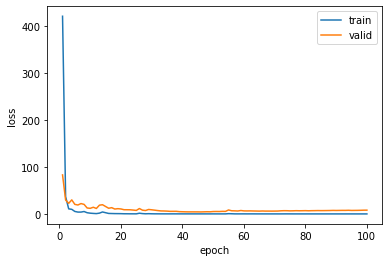

In [91]:
cnn1_2_trainer.learning_curve()

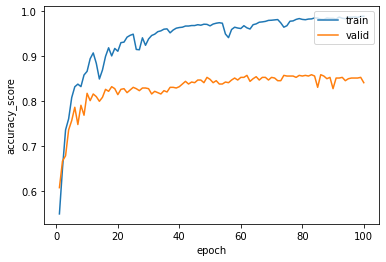

In [92]:
cnn1_2_trainer.learning_curve(y='accuracy_score')

In [93]:
sort_epochs(cnn1_2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
165        0.858407   83.0      0.844371        0.838816      0.874332
171        0.858407   86.0      0.846667        0.835526      0.877005
147        0.856932   74.0      0.865724        0.805921      0.898396
123        0.856932   62.0      0.863158        0.809211      0.895722
157        0.856932   79.0      0.841584        0.838816      0.871658
..              ...    ...           ...             ...           ...
13         0.747788    7.0      0.884393        0.503289      0.946524
7          0.735988    4.0      0.827225        0.519737      0.911765
5          0.678466    3.0      0.835938        0.351974      0.943850
3          0.666667    2.0      0.791045        0.348684      0.925134
1          0.607670    1.0      0.702128        0.217105      0.925134

[100 rows x 5 columns]


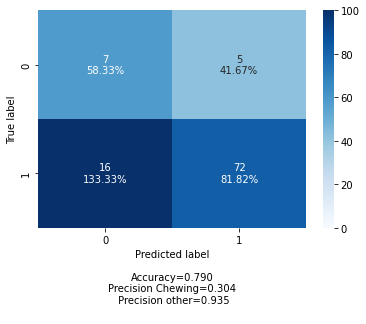

In [94]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn1_2_model = cnn1_2_model.cuda()

with torch.no_grad():
        pred_y = cnn1_2_model(test_X)
        pred_y = cnn1_2_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# 2conv1lin

In [95]:
class cnn2Layer1(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(self.out_channels, 2*self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(2*self.out_channels*8*50 , 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = X.reshape(-1, 2*self.out_channels*8*50)
        X = self.w1(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [96]:
cnn2_model = cnn2Layer1(4)
cnn2_trainer = trainer(cnn2_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn2_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/345600 [00:00<?, ?it/s]

  1 2.04s trainloss=23.53371 validloss=10.79652 accuracy_score=0.75811 
  2 2.04s trainloss=5.04971 validloss=7.57817 accuracy_score=0.79794 
  3 2.04s trainloss=1.89043 validloss=5.72079 accuracy_score=0.82006 
  4 2.05s trainloss=1.14902 validloss=4.74243 accuracy_score=0.84956 
  5 2.05s trainloss=0.72156 validloss=3.83475 accuracy_score=0.83333 
  6 2.04s trainloss=0.52227 validloss=3.75268 accuracy_score=0.85546 
  7 2.04s trainloss=0.38597 validloss=3.65273 accuracy_score=0.84956 
  8 2.04s trainloss=0.27446 validloss=3.68437 accuracy_score=0.84956 
  9 2.04s trainloss=0.23708 validloss=2.97286 accuracy_score=0.84513 
 10 2.03s trainloss=0.23911 validloss=3.34845 accuracy_score=0.84956 
 11 2.04s trainloss=0.20945 validloss=2.79961 accuracy_score=0.83333 
 12 2.21s trainloss=0.21898 validloss=3.06216 accuracy_score=0.85103 
 13 2.04s trainloss=0.18111 validloss=3.24667 accuracy_score=0.84218 
 14 2.04s trainloss=0.76499 validloss=3.40209 accuracy_score=0.84661 
 15 2.04s trainlos

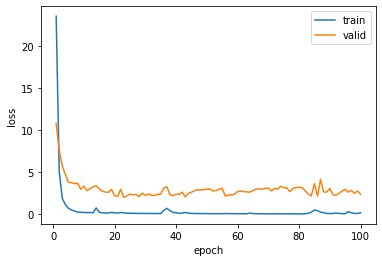

In [97]:
cnn2_trainer.learning_curve()

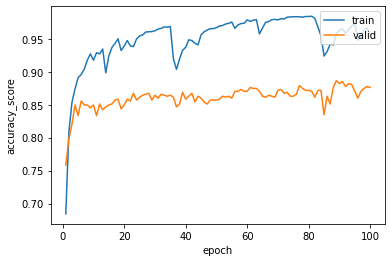

In [98]:
cnn2_trainer.learning_curve(y='accuracy_score')

In [99]:
sort_epochs(cnn2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
177        0.886431   89.0      0.853583        0.901316      0.874332
181        0.884956   91.0      0.866883        0.878289      0.890374
179        0.882006   90.0      0.843558        0.904605      0.863636
185        0.882006   93.0      0.854430        0.888158      0.877005
187        0.880531   94.0      0.836858        0.911184      0.855615
..              ...    ...           ...             ...           ...
21         0.833333   11.0      0.805112        0.828947      0.836898
9          0.833333    5.0      0.778426        0.878289      0.796791
5          0.820059    3.0      0.774096        0.845395      0.799465
3          0.797935    2.0      0.753799        0.815789      0.783422
1          0.758112    1.0      0.827103        0.582237      0.901070

[100 rows x 5 columns]


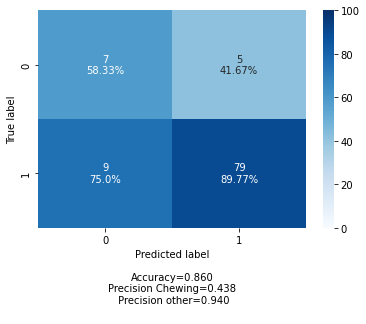

In [100]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn2_model = cnn2_model.cuda()

with torch.no_grad():
        pred_y = cnn2_model(test_X)
        pred_y = cnn2_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# 2conv2lin

In [101]:
class cnn2Layer2(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(self.out_channels, 2*self.out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.w1 = nn.Linear(2*self.out_channels*8*50 , 100)
        self.w2 = nn.Linear(100, 2)
        
    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = X.reshape(-1, 2*self.out_channels*8*50)
        X = self.w1(X)
        X = self.w2(X)
        return X
        
    def post_forward(self, y):
        return torch.argmax(y, axis=1)

In [102]:
cnn2_2_model = cnn2Layer2(4)
cnn2_2_trainer = trainer(cnn2_2_model, nn.CrossEntropyLoss(), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)
cnn2_2_trainer.train(100, lr=[0.01, 0.001])

Total:   0%|          | 0/345600 [00:00<?, ?it/s]

  1 2.09s trainloss=43.00159 validloss=8.64678 accuracy_score=0.75516 
  2 2.09s trainloss=2.91100 validloss=4.14914 accuracy_score=0.77876 
  3 2.09s trainloss=1.99780 validloss=4.85274 accuracy_score=0.81711 
  4 2.07s trainloss=1.02504 validloss=3.41142 accuracy_score=0.82448 
  5 2.02s trainloss=0.63968 validloss=2.72155 accuracy_score=0.84218 
  6 2.07s trainloss=0.46484 validloss=2.48064 accuracy_score=0.84808 
  7 2.07s trainloss=0.37773 validloss=2.24245 accuracy_score=0.84956 
  8 2.08s trainloss=0.28039 validloss=2.62893 accuracy_score=0.85546 
  9 2.11s trainloss=0.39203 validloss=3.39233 accuracy_score=0.83481 
 10 2.08s trainloss=0.52320 validloss=2.87948 accuracy_score=0.84808 
 11 2.07s trainloss=0.30834 validloss=2.13190 accuracy_score=0.86873 
 12 2.09s trainloss=0.28618 validloss=2.40725 accuracy_score=0.87463 
 13 2.07s trainloss=0.25975 validloss=2.34990 accuracy_score=0.86578 
 14 2.07s trainloss=0.19498 validloss=2.24004 accuracy_score=0.87316 
 15 2.07s trainloss

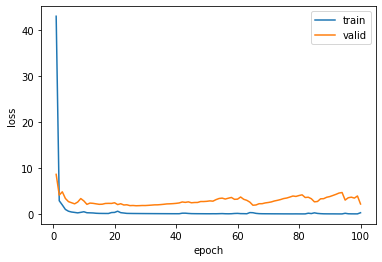

In [103]:
cnn2_2_trainer.learning_curve()

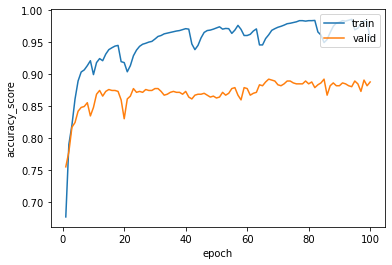

In [104]:
cnn2_2_trainer.learning_curve(y='accuracy_score')

In [105]:
sort_epochs(cnn2_2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
169        0.892330   85.0      0.862069        0.904605      0.882353
133        0.892330   67.0      0.844776        0.930921      0.860963
195        0.890855   98.0      0.861635        0.901316      0.882353
135        0.890855   68.0      0.848485        0.921053      0.866310
157        0.889381   79.0      0.854489        0.907895      0.874332
..              ...    ...           ...             ...           ...
39         0.830383   20.0      0.851301        0.753289      0.893048
7          0.824484    4.0      0.793651        0.822368      0.826203
5          0.817109    3.0      0.781250        0.822368      0.812834
3          0.778761    2.0      0.850000        0.615132      0.911765
1          0.755162    1.0      0.767442        0.651316      0.839572

[100 rows x 5 columns]


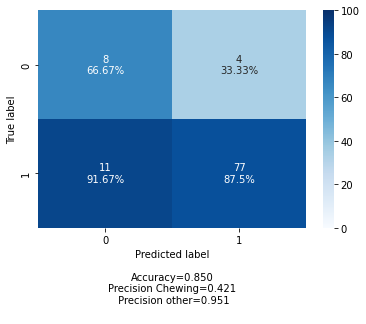

In [106]:
test_X, test_y = next(iter(test_loader))
test_X = test_X.cuda()
test_y = test_y.cuda()
cnn2_2_model = cnn2_2_model.cuda()

with torch.no_grad():
        pred_y = cnn2_2_model(test_X)
        pred_y = cnn2_2_model.post_forward(pred_y)
        
make_confusion_matrix(test_y.cpu(), pred_y.cpu())

# ResNet

In [12]:
# nSamples = [1696, 2216, 3920] #of class instances
nSamples = [1696, 2216 + 3920] #of class instances
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights).cuda()

In [13]:
def post_forward(y):
    return torch.argmax(y, axis=1)

# resnet 18

In [49]:
rn18 = models.resnet18(pretrained=True)
rn18.conv1 = nn.Conv2d(1, rn18.conv1.out_channels,
              kernel_size=rn18.conv1.kernel_size[0], 
                      stride=rn18.conv1.stride[0], 
                      padding=rn18.conv1.padding[0])
num_ftrs = rn18.fc.in_features
rn18.fc = nn.Linear(num_ftrs, 2)

rn18.post_forward = post_forward

rn18_trainer = trainer(rn18, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [53]:
rn18_trainer.train(100, lr=0.01, weight_decay=0.8)

Total:   0%|          | 0/345600 [00:00<?, ?it/s]

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 21 3.03s trainloss=0.30472 validloss=1.78367 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 22 3.18s trainloss=0.28017 validloss=7.24798 accuracy_score=0.50590 
 23 3.01s trainloss=0.30682 validloss=0.61548 accuracy_score=0.87758 
 24 3.11s trainloss=0.30130 validloss=1.04644 accuracy_score=0.46608 
 25 3.61s trainloss=0.29390 validloss=0.30408 accuracy_score=0.82301 
 26 3.52s trainloss=0.29811 validloss=1.36700 accuracy_score=0.55752 
 27 3.61s trainloss=0.29018 validloss=0.41567 accuracy_score=0.57965 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 28 3.94s trainloss=0.29632 validloss=0.81028 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 29 3.95s trainloss=0.28993 validloss=0.55405 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 30 3.96s trainloss=0.29171 validloss=2.69780 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 31 3.96s trainloss=0.30052 validloss=2.35347 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 32 3.97s trainloss=0.29845 validloss=2.19736 accuracy_score=0.50590 
 33 3.95s trainloss=0.29603 validloss=0.57398 accuracy_score=0.71239 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 34 3.96s trainloss=0.29010 validloss=2.59566 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 35 3.53s trainloss=0.25985 validloss=6.27977 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 36 3.49s trainloss=0.27450 validloss=2.98424 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 37 3.38s trainloss=0.26188 validloss=1.11314 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 38 2.99s trainloss=0.27711 validloss=2.20402 accuracy_score=0.50590 
 39 3.12s trainloss=0.31901 validloss=0.53110 accuracy_score=0.49558 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 40 3.16s trainloss=0.30376 validloss=0.89507 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 41 2.98s trainloss=0.27054 validloss=2.13270 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 42 3.34s trainloss=0.28149 validloss=1.27033 accuracy_score=0.50590 
 43 2.98s trainloss=0.28830 validloss=0.98011 accuracy_score=0.72124 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 44 3.00s trainloss=0.30296 validloss=1.06341 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 45 3.01s trainloss=0.28047 validloss=1.25150 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 46 3.00s trainloss=0.28470 validloss=4.11151 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 47 3.28s trainloss=0.31296 validloss=1.63786 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 48 3.52s trainloss=0.28573 validloss=2.08708 accuracy_score=0.50590 
 49 3.58s trainloss=0.27766 validloss=0.54889 accuracy_score=0.57227 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 50 3.64s trainloss=0.27073 validloss=2.97262 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 51 3.94s trainloss=0.30508 validloss=2.30548 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 52 4.22s trainloss=0.33313 validloss=0.91450 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 53 4.11s trainloss=0.29371 validloss=1.56574 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 54 4.13s trainloss=0.27766 validloss=2.62413 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 55 4.12s trainloss=0.27416 validloss=2.91835 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 56 4.12s trainloss=0.43321 validloss=0.54696 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 57 4.11s trainloss=0.52872 validloss=0.53223 accuracy_score=0.49410 
 58 4.12s trainloss=0.47456 validloss=0.76946 accuracy_score=0.50000 
 59 4.11s trainloss=0.34070 validloss=0.64854 accuracy_score=0.62389 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 4.12s trainloss=0.32363 validloss=0.77895 accuracy_score=0.50590 
 61 4.10s trainloss=0.32607 validloss=0.58063 accuracy_score=0.66372 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 62 4.22s trainloss=0.31999 validloss=1.12991 accuracy_score=0.50590 
 63 4.13s trainloss=0.31565 validloss=0.48008 accuracy_score=0.71534 
 64 4.13s trainloss=0.34052 validloss=1.01970 accuracy_score=0.60177 
 65 4.18s trainloss=0.31204 validloss=1.13187 accuracy_score=0.58850 
 66 4.13s trainloss=0.32767 validloss=0.30869 accuracy_score=0.83628 
 67 4.08s trainloss=0.30446 validloss=0.48773 accuracy_score=0.86578 
 68 4.10s trainloss=0.30744 validloss=1.56574 accuracy_score=0.62832 
 69 4.08s trainloss=0.30000 validloss=2.67970 accuracy_score=0.55015 
 70 4.08s trainloss=0.29466 validloss=1.76610 accuracy_score=0.56047 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 71 4.12s trainloss=0.29471 validloss=1.38839 accuracy_score=0.50590 
 72 4.12s trainloss=0.29326 validloss=7.28539 accuracy_score=0.52507 
 73 4.01s trainloss=0.28983 validloss=4.86689 accuracy_score=0.50885 
 74 3.51s trainloss=0.29085 validloss=2.14644 accuracy_score=0.58555 
 75 3.53s trainloss=0.29769 validloss=2.91587 accuracy_score=0.56637 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 76 3.53s trainloss=0.28855 validloss=1.47610 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 77 3.57s trainloss=0.27757 validloss=0.97191 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 78 3.56s trainloss=0.28977 validloss=0.88200 accuracy_score=0.50590 
 79 3.57s trainloss=0.29270 validloss=1.00483 accuracy_score=0.63422 
 80 3.58s trainloss=0.28758 validloss=2.28444 accuracy_score=0.62094 
 81 3.58s trainloss=0.28795 validloss=11.14157 accuracy_score=0.51180 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 82 3.57s trainloss=0.30492 validloss=1.19292 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 83 3.54s trainloss=0.29334 validloss=1.32690 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 84 3.79s trainloss=0.28869 validloss=1.41989 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85 3.92s trainloss=0.28439 validloss=1.31972 accuracy_score=0.50590 
 86 4.01s trainloss=0.29497 validloss=1.85128 accuracy_score=0.60472 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 87 4.02s trainloss=0.28450 validloss=1.25818 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88 4.12s trainloss=0.28937 validloss=1.22951 accuracy_score=0.50590 
 89 4.11s trainloss=0.30267 validloss=2.36423 accuracy_score=0.59292 
 90 4.03s trainloss=0.28526 validloss=0.89577 accuracy_score=0.67847 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 91 4.05s trainloss=0.28338 validloss=25.33331 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 92 4.07s trainloss=0.29005 validloss=1.26042 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 93 4.07s trainloss=0.28229 validloss=1.31866 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 94 4.07s trainloss=0.28921 validloss=1.14803 accuracy_score=0.50590 
 95 4.06s trainloss=0.28523 validloss=0.84010 accuracy_score=0.71239 
 96 4.08s trainloss=0.28291 validloss=5.29581 accuracy_score=0.52360 
 97 4.06s trainloss=0.28468 validloss=0.26069 accuracy_score=0.83038 
 98 3.66s trainloss=0.28846 validloss=0.35636 accuracy_score=0.79056 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 99 3.44s trainloss=0.27404 validloss=1.32075 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


100 3.46s trainloss=0.28928 validloss=1.33644 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


101 3.46s trainloss=0.27948 validloss=8.13013 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


102 3.45s trainloss=0.40826 validloss=0.53131 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


103 3.46s trainloss=0.52909 validloss=0.54941 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


104 3.46s trainloss=0.54040 validloss=0.53154 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


105 3.47s trainloss=0.53114 validloss=0.53060 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


106 3.49s trainloss=0.52670 validloss=0.53974 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


107 3.50s trainloss=0.53079 validloss=0.53534 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


108 3.49s trainloss=0.52832 validloss=0.53003 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


109 3.49s trainloss=0.52535 validloss=0.53252 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


110 3.49s trainloss=0.52674 validloss=0.53903 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


111 3.61s trainloss=0.52726 validloss=0.54437 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


112 3.48s trainloss=0.52561 validloss=0.53321 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


113 3.49s trainloss=0.52488 validloss=0.53532 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


114 3.49s trainloss=0.52586 validloss=0.53584 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


115 3.52s trainloss=0.52937 validloss=0.53363 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


116 3.48s trainloss=0.52679 validloss=0.53432 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


117 3.48s trainloss=0.52714 validloss=0.54032 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


118 3.48s trainloss=0.53022 validloss=0.53098 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


119 3.48s trainloss=0.52617 validloss=0.53196 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


120 3.48s trainloss=0.52692 validloss=0.53161 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


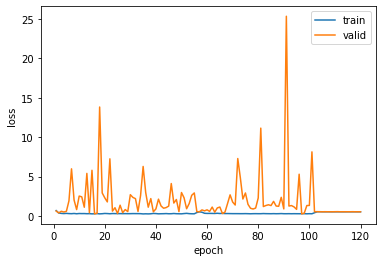

In [54]:
rn18_trainer.learning_curve()

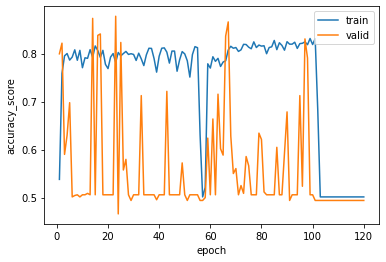

In [55]:
rn18_trainer.learning_curve(y='accuracy_score')

In [56]:
sort_epochs(rn18_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
45         0.877581   23.0      0.886503        0.862687      0.892128
27         0.873156   14.0      0.871642        0.871642      0.874636
133        0.865782   67.0      0.874233        0.850746      0.880466
33         0.840708   17.0      0.774818        0.955224      0.728863
31         0.837758   16.0      0.767221        0.964179      0.714286
..              ...    ...           ...             ...           ...
101        0.494100   51.0      0.494100        1.000000      0.000000
111        0.494100   56.0      0.494100        1.000000      0.000000
113        0.494100   57.0      0.494100        1.000000      0.000000
239        0.494100  120.0      0.494100        1.000000      0.000000
47         0.466077   24.0      0.000000        0.000000      0.921283

[120 rows x 5 columns]


# resnet 34

In [57]:
rn34 = models.resnet34(pretrained=True)
rn34.conv1 = nn.Conv2d(1, rn34.conv1.out_channels,
              kernel_size=rn34.conv1.kernel_size[0], 
                      stride=rn34.conv1.stride[0], 
                      padding=rn34.conv1.padding[0])
num_ftrs = rn34.fc.in_features
rn34.fc = nn.Linear(num_ftrs, 2)

rn34.post_forward = post_forward

rn34_trainer = trainer(rn18, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [58]:
rn34_trainer.train(100, lr=0.01, weight_decay=0.5)

Total:   0%|          | 0/345600 [00:00<?, ?it/s]

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  1 3.42s trainloss=0.53130 validloss=0.53036 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  2 3.40s trainloss=0.52541 validloss=0.53706 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  3 3.39s trainloss=0.52829 validloss=0.52998 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  4 3.44s trainloss=0.52654 validloss=0.53518 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  5 3.81s trainloss=0.52908 validloss=0.53261 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  6 3.97s trainloss=0.53195 validloss=0.53021 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  7 4.31s trainloss=0.52748 validloss=0.53343 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  8 4.61s trainloss=0.52714 validloss=0.53309 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  9 4.57s trainloss=0.52871 validloss=0.53221 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 10 4.55s trainloss=0.52422 validloss=0.53243 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 11 4.60s trainloss=0.52739 validloss=0.53029 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 12 4.61s trainloss=0.52399 validloss=0.53236 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 13 4.62s trainloss=0.52569 validloss=0.53185 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 14 4.61s trainloss=0.52625 validloss=0.54104 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 15 4.45s trainloss=0.52882 validloss=0.53568 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 16 4.16s trainloss=0.53318 validloss=0.54414 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 17 3.79s trainloss=0.52876 validloss=0.53226 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 18 3.52s trainloss=0.52564 validloss=0.53411 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 19 3.10s trainloss=0.52529 validloss=0.53567 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 20 2.91s trainloss=0.52577 validloss=0.54107 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 21 2.94s trainloss=0.52819 validloss=0.53178 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 22 2.94s trainloss=0.52751 validloss=0.53966 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 23 2.94s trainloss=0.52741 validloss=0.53571 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 24 2.94s trainloss=0.53141 validloss=0.53045 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 25 2.94s trainloss=0.52629 validloss=0.53158 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 26 2.94s trainloss=0.52805 validloss=0.53076 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 27 2.94s trainloss=0.52730 validloss=0.53366 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 28 2.94s trainloss=0.52598 validloss=0.52977 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 29 2.94s trainloss=0.52580 validloss=0.53049 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 30 2.95s trainloss=0.52928 validloss=0.53409 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 31 2.95s trainloss=0.53182 validloss=0.53508 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 32 3.01s trainloss=0.52746 validloss=0.53778 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 33 3.55s trainloss=0.52800 validloss=0.53420 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 34 3.34s trainloss=0.52698 validloss=0.53290 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 35 3.34s trainloss=0.52812 validloss=0.53135 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 36 3.35s trainloss=0.52473 validloss=0.53181 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 37 3.35s trainloss=0.52564 validloss=0.53248 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 38 3.36s trainloss=0.52809 validloss=0.53941 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 39 3.36s trainloss=0.52607 validloss=0.53435 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 40 3.36s trainloss=0.52992 validloss=0.53209 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 41 3.36s trainloss=0.53181 validloss=0.53227 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 42 3.35s trainloss=0.52515 validloss=0.53404 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 43 3.36s trainloss=0.52699 validloss=0.53354 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 44 3.35s trainloss=0.52342 validloss=0.53023 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 45 3.16s trainloss=0.52516 validloss=0.53475 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 46 3.22s trainloss=0.52569 validloss=0.53461 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 47 3.48s trainloss=0.52727 validloss=0.53205 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 48 3.48s trainloss=0.53000 validloss=0.53028 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 49 3.45s trainloss=0.52628 validloss=0.53165 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 50 3.45s trainloss=0.52576 validloss=0.53228 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 51 3.45s trainloss=0.52548 validloss=0.53416 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 52 3.45s trainloss=0.52967 validloss=0.53185 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 53 3.45s trainloss=0.52772 validloss=0.53576 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 54 3.45s trainloss=0.52643 validloss=0.53383 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 55 3.44s trainloss=0.52798 validloss=0.53036 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 56 3.54s trainloss=0.52680 validloss=0.53695 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 57 3.76s trainloss=0.52849 validloss=0.52989 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 58 3.86s trainloss=0.52991 validloss=0.53037 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 59 3.88s trainloss=0.52371 validloss=0.53125 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 3.89s trainloss=0.52675 validloss=0.52918 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 61 3.89s trainloss=0.52793 validloss=0.54030 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 62 3.88s trainloss=0.52696 validloss=0.53097 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 63 3.87s trainloss=0.53134 validloss=0.53791 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 64 3.84s trainloss=0.53017 validloss=0.53503 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 65 3.86s trainloss=0.52514 validloss=0.53190 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 66 3.88s trainloss=0.53203 validloss=0.53085 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 67 3.88s trainloss=0.52694 validloss=0.53637 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 68 3.51s trainloss=0.52962 validloss=0.53153 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 69 3.44s trainloss=0.52821 validloss=0.53057 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 70 3.16s trainloss=0.52974 validloss=0.53457 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 71 3.06s trainloss=0.52441 validloss=0.52975 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 72 2.94s trainloss=0.52681 validloss=0.53200 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 73 2.94s trainloss=0.52872 validloss=0.53340 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 74 2.95s trainloss=0.52753 validloss=0.53024 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 75 2.94s trainloss=0.52567 validloss=0.53378 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 76 2.94s trainloss=0.52839 validloss=0.53069 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 77 2.94s trainloss=0.52591 validloss=0.53690 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 78 2.95s trainloss=0.52708 validloss=0.53362 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 79 2.94s trainloss=0.52764 validloss=0.52920 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 80 2.95s trainloss=0.52804 validloss=0.53356 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 81 2.95s trainloss=0.52608 validloss=0.53289 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 82 2.96s trainloss=0.52702 validloss=0.53069 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 83 3.12s trainloss=0.52548 validloss=0.53185 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 84 3.44s trainloss=0.53047 validloss=0.53343 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85 3.52s trainloss=0.52644 validloss=0.53150 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 86 3.47s trainloss=0.52704 validloss=0.53142 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 87 3.47s trainloss=0.52365 validloss=0.53019 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88 3.48s trainloss=0.52548 validloss=0.53222 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 89 3.46s trainloss=0.52590 validloss=0.53557 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 90 3.47s trainloss=0.52563 validloss=0.53583 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 91 3.46s trainloss=0.52623 validloss=0.53271 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 92 3.47s trainloss=0.52620 validloss=0.53096 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 93 3.47s trainloss=0.52742 validloss=0.53509 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 94 3.46s trainloss=0.52784 validloss=0.55651 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 95 3.47s trainloss=0.53186 validloss=0.53102 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 96 3.54s trainloss=0.52669 validloss=0.54632 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 97 4.07s trainloss=0.52903 validloss=0.53140 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 98 4.22s trainloss=0.52542 validloss=0.53015 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 99 3.65s trainloss=0.52532 validloss=0.53322 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


100 3.78s trainloss=0.52619 validloss=0.53526 accuracy_score=0.49410 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


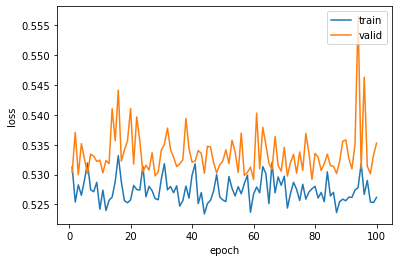

In [59]:
rn34_trainer.learning_curve()

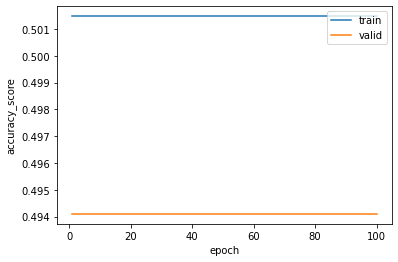

In [60]:
rn34_trainer.learning_curve(y='accuracy_score')

In [61]:
sort_epochs(rn34_trainer.evalutator, 'accuracy_score')

AttributeError: 'trainer' object has no attribute 'evalutator'

# resnet 152

In [62]:
rn_152 = models.resnet152(pretrained=True)

rn_152.conv1 = nn.Conv2d(1, rn_152.conv1.out_channels,
              kernel_size=rn_152.conv1.kernel_size[0], 
                      stride=rn_152.conv1.stride[0], 
                      padding=rn_152.conv1.padding[0])
num_ftrs = rn_152.fc.in_features
rn_152.fc = nn.Linear(num_ftrs, 2)

rn_152.post_forward = post_forward

rn_152_trainer = trainer(rn_152, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/17113571/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [63]:
rn_152_trainer.train(100, lr=0.01, weight_decay=0.2)

Total:   0%|          | 0/345600 [00:00<?, ?it/s]

  1 10.60s trainloss=0.54648 validloss=0.95113 accuracy_score=0.53392 
  2 11.05s trainloss=0.32782 validloss=0.58610 accuracy_score=0.60767 
  3 12.78s trainloss=0.33474 validloss=1.03299 accuracy_score=0.60914 
  4 12.71s trainloss=0.30894 validloss=0.82485 accuracy_score=0.73156 
  5 12.63s trainloss=0.26208 validloss=0.85109 accuracy_score=0.50295 
  6 12.69s trainloss=0.26174 validloss=0.54470 accuracy_score=0.88938 
  7 11.71s trainloss=0.26351 validloss=0.72908 accuracy_score=0.57375 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  8 9.56s trainloss=0.25483 validloss=3.59202 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  9 9.01s trainloss=0.26474 validloss=4.00984 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 10 9.02s trainloss=0.25253 validloss=3.64226 accuracy_score=0.50590 
 11 9.01s trainloss=0.22874 validloss=1.00558 accuracy_score=0.63864 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 12 9.15s trainloss=0.23643 validloss=2.88519 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 13 9.14s trainloss=0.23407 validloss=5.04002 accuracy_score=0.50590 
 14 9.12s trainloss=0.22956 validloss=0.42576 accuracy_score=0.69764 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 15 9.35s trainloss=0.23934 validloss=0.53267 accuracy_score=0.49410 
 16 10.41s trainloss=0.22354 validloss=1.20935 accuracy_score=0.50295 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 17 10.42s trainloss=0.21622 validloss=6.13751 accuracy_score=0.50590 
 18 11.26s trainloss=0.21721 validloss=0.93763 accuracy_score=0.49705 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 19 12.36s trainloss=0.24010 validloss=8.13483 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 20 11.72s trainloss=0.20818 validloss=11.39004 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 21 11.69s trainloss=0.22578 validloss=10.58649 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 22 11.85s trainloss=0.22237 validloss=8.58955 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 23 11.51s trainloss=0.21877 validloss=3.90228 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 24 9.10s trainloss=0.21268 validloss=3.66268 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 25 9.13s trainloss=0.22905 validloss=22.89489 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 26 9.07s trainloss=0.23137 validloss=4.32290 accuracy_score=0.50590 
 27 9.08s trainloss=0.23551 validloss=0.66412 accuracy_score=0.58112 
 28 9.93s trainloss=0.21838 validloss=0.57852 accuracy_score=0.72271 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 29 10.91s trainloss=0.22207 validloss=9.68731 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 30 12.32s trainloss=0.22168 validloss=3.29570 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 31 12.41s trainloss=0.21008 validloss=7.36298 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 32 12.46s trainloss=0.24138 validloss=1.20132 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 33 12.52s trainloss=0.21842 validloss=14.17141 accuracy_score=0.50590 
 34 12.54s trainloss=0.21284 validloss=2.22356 accuracy_score=0.50295 
 35 12.53s trainloss=0.20824 validloss=0.87352 accuracy_score=0.48083 
 36 12.37s trainloss=0.25287 validloss=0.45286 accuracy_score=0.86578 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 37 12.36s trainloss=0.21898 validloss=4.63977 accuracy_score=0.50590 
 38 11.45s trainloss=0.21309 validloss=0.63354 accuracy_score=0.54277 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 39 10.69s trainloss=0.19968 validloss=16.91601 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 40 10.80s trainloss=0.19510 validloss=17.88577 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 41 10.64s trainloss=0.19767 validloss=17.33548 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 42 9.19s trainloss=0.19857 validloss=5.63335 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 43 8.95s trainloss=0.21818 validloss=0.83221 accuracy_score=0.50590 
 44 8.96s trainloss=0.23652 validloss=0.26948 accuracy_score=0.79204 
 45 8.96s trainloss=0.20791 validloss=0.27446 accuracy_score=0.86136 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 46 9.08s trainloss=0.20196 validloss=14.25278 accuracy_score=0.50590 
 47 9.07s trainloss=0.19494 validloss=0.46132 accuracy_score=0.74779 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 48 9.06s trainloss=0.19354 validloss=6.17347 accuracy_score=0.50590 
 49 8.97s trainloss=0.20613 validloss=0.25023 accuracy_score=0.82006 
 50 9.01s trainloss=0.19153 validloss=3.61950 accuracy_score=0.50737 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 51 9.02s trainloss=0.19132 validloss=2.06555 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 52 8.98s trainloss=0.18864 validloss=3.96494 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 53 9.02s trainloss=0.18271 validloss=20.35136 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 54 8.87s trainloss=0.18588 validloss=2.84460 accuracy_score=0.50590 
 55 9.62s trainloss=0.27369 validloss=0.36908 accuracy_score=0.51180 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 56 10.26s trainloss=0.35335 validloss=61.92538 accuracy_score=0.50590 
 57 10.38s trainloss=0.28969 validloss=0.65717 accuracy_score=0.75369 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 58 11.16s trainloss=0.25392 validloss=3.50558 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 59 11.16s trainloss=0.24886 validloss=7.74719 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 11.17s trainloss=0.24269 validloss=9.27308 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 61 10.68s trainloss=0.23506 validloss=6.04020 accuracy_score=0.50590 
 62 10.32s trainloss=0.21744 validloss=3.77508 accuracy_score=0.49558 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 63 10.30s trainloss=0.21201 validloss=8.78824 accuracy_score=0.50590 
 64 10.47s trainloss=0.22710 validloss=1.84022 accuracy_score=0.50295 
 65 10.40s trainloss=0.22359 validloss=0.67878 accuracy_score=0.58555 
 66 10.34s trainloss=0.21940 validloss=0.25138 accuracy_score=0.80973 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 67 10.37s trainloss=0.23208 validloss=3.40498 accuracy_score=0.50590 
 68 10.41s trainloss=0.20982 validloss=1.92710 accuracy_score=0.50442 
 69 10.35s trainloss=0.23066 validloss=0.25371 accuracy_score=0.79056 
 70 10.35s trainloss=0.23715 validloss=1.53758 accuracy_score=0.50000 
 71 10.40s trainloss=0.20097 validloss=0.70790 accuracy_score=0.63717 
 72 10.40s trainloss=0.19401 validloss=2.32534 accuracy_score=0.50000 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 73 10.33s trainloss=0.21747 validloss=9.34302 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 74 10.31s trainloss=0.21317 validloss=8.17696 accuracy_score=0.50590 
 75 10.30s trainloss=0.21278 validloss=0.55261 accuracy_score=0.68437 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 76 9.98s trainloss=0.21490 validloss=6.04098 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 77 9.07s trainloss=0.20085 validloss=6.15998 accuracy_score=0.50590 
 78 9.04s trainloss=0.19684 validloss=4.14209 accuracy_score=0.50295 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 79 9.06s trainloss=0.21538 validloss=10.05110 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 80 9.05s trainloss=0.20629 validloss=10.15806 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 81 9.22s trainloss=0.21765 validloss=5.35975 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 82 9.00s trainloss=0.21938 validloss=6.32617 accuracy_score=0.50590 
 83 9.05s trainloss=0.23295 validloss=0.52502 accuracy_score=0.74189 
 84 9.05s trainloss=0.23314 validloss=4.00539 accuracy_score=0.50295 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85 9.41s trainloss=0.21862 validloss=5.74304 accuracy_score=0.50590 
 86 12.06s trainloss=0.21285 validloss=2.99004 accuracy_score=0.50442 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 87 13.47s trainloss=0.20762 validloss=3.49485 accuracy_score=0.50590 
 88 13.45s trainloss=0.19173 validloss=0.67264 accuracy_score=0.83628 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 89 13.48s trainloss=0.20381 validloss=3.54179 accuracy_score=0.50590 
 90 13.23s trainloss=0.20800 validloss=0.82588 accuracy_score=0.50147 
 91 13.33s trainloss=0.19119 validloss=1.56951 accuracy_score=0.50295 
 92 12.12s trainloss=0.20960 validloss=0.92780 accuracy_score=0.52950 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 93 10.80s trainloss=0.20031 validloss=7.13936 accuracy_score=0.50590 
 94 10.75s trainloss=0.21747 validloss=0.33668 accuracy_score=0.73009 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 95 10.65s trainloss=0.24446 validloss=2.29981 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 96 9.52s trainloss=0.24233 validloss=0.91291 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 97 8.98s trainloss=0.23750 validloss=4.01882 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 98 9.02s trainloss=0.22172 validloss=3.25562 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 99 9.05s trainloss=0.21821 validloss=13.23409 accuracy_score=0.50590 
100 9.15s trainloss=0.22213 validloss=0.43616 accuracy_score=0.60767 


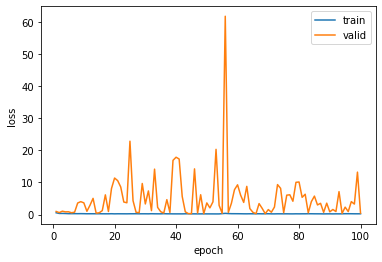

In [64]:
rn_152_trainer.learning_curve()

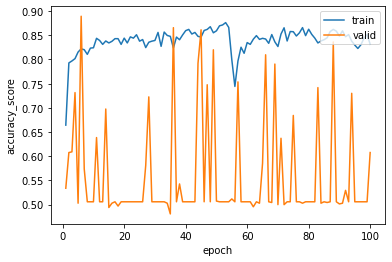

In [65]:
rn_152_trainer.learning_curve(y='accuracy_score')

In [66]:
sort_epochs(rn_152_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
11         0.889381    6.0      0.896341        0.877612      0.900875
71         0.865782   36.0      0.808081        0.955224      0.778426
89         0.861357   45.0      0.791768        0.976119      0.749271
175        0.836283   88.0      0.917910        0.734328      0.935860
97         0.820059   49.0      0.741497        0.976119      0.667638
..              ...    ...           ...             ...           ...
143        0.500000   72.0      0.000000        0.000000      0.988338
35         0.497050   18.0      0.495562        1.000000      0.005831
123        0.495575   62.0      0.111111        0.002985      0.976676
29         0.494100   15.0      0.494100        1.000000      0.000000
69         0.480826   35.0      0.095238        0.005970      0.944606

[100 rows x 5 columns]


# wide resnet 50_2

In [67]:
rn50_2 = models.wide_resnet50_2(pretrained=True)
rn50_2.conv1 = nn.Conv2d(1, rn50_2.conv1.out_channels,
              kernel_size=rn50_2.conv1.kernel_size[0], 
                      stride=rn50_2.conv1.stride[0], 
                      padding=rn50_2.conv1.padding[0])
num_ftrs = rn50_2.fc.in_features
rn50_2.fc = nn.Linear(num_ftrs, 2)

rn50_2.post_forward = post_forward

rn50_2_trainer = trainer(rn50_2, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /home/17113571/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [68]:
rn50_2_trainer.train(100, lr=0.01, weight_decay=0.4)

Total:   0%|          | 0/345600 [00:00<?, ?it/s]

  1 10.28s trainloss=0.76522 validloss=0.50461 accuracy_score=0.78466 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  2 10.40s trainloss=0.45713 validloss=0.96524 accuracy_score=0.50590 
  3 10.35s trainloss=0.35299 validloss=0.39559 accuracy_score=0.67109 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  4 10.24s trainloss=0.30998 validloss=1.43865 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  5 10.30s trainloss=0.31855 validloss=2.93570 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  6 10.27s trainloss=0.31025 validloss=1.49684 accuracy_score=0.50590 
  7 10.32s trainloss=0.28467 validloss=0.51006 accuracy_score=0.69912 
  8 10.43s trainloss=0.27528 validloss=0.66428 accuracy_score=0.70059 
  9 9.58s trainloss=0.25174 validloss=0.62094 accuracy_score=0.61209 
 10 8.16s trainloss=0.24353 validloss=0.31716 accuracy_score=0.74779 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 11 7.19s trainloss=0.27352 validloss=6.47539 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 12 7.18s trainloss=0.25080 validloss=0.71505 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 13 7.21s trainloss=0.25117 validloss=1.00881 accuracy_score=0.50590 
 14 7.18s trainloss=0.29235 validloss=0.78649 accuracy_score=0.61357 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 15 7.20s trainloss=0.26667 validloss=2.40192 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 16 7.20s trainloss=0.23892 validloss=5.48711 accuracy_score=0.50590 
 17 7.20s trainloss=0.26460 validloss=0.37490 accuracy_score=0.74484 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 18 7.21s trainloss=0.24509 validloss=2.02413 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 19 7.18s trainloss=0.26363 validloss=1.68131 accuracy_score=0.50590 
 20 7.23s trainloss=0.24472 validloss=0.58014 accuracy_score=0.87021 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 21 7.20s trainloss=0.23931 validloss=4.78568 accuracy_score=0.50590 
 22 7.21s trainloss=0.24842 validloss=0.57151 accuracy_score=0.75811 
 23 7.17s trainloss=0.24859 validloss=0.28263 accuracy_score=0.81858 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 24 7.15s trainloss=0.24182 validloss=3.88461 accuracy_score=0.50590 
 25 7.20s trainloss=0.25112 validloss=1.00020 accuracy_score=0.62094 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 26 7.18s trainloss=0.24425 validloss=4.16895 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 27 7.20s trainloss=0.22515 validloss=2.49524 accuracy_score=0.50590 
 28 7.41s trainloss=0.25952 validloss=0.42717 accuracy_score=0.76106 
 29 7.17s trainloss=0.23967 validloss=0.26268 accuracy_score=0.80236 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 30 7.20s trainloss=0.24755 validloss=3.09757 accuracy_score=0.50590 
 31 7.15s trainloss=0.24792 validloss=0.65325 accuracy_score=0.47345 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 32 7.15s trainloss=0.25788 validloss=2.97211 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 33 7.14s trainloss=0.24351 validloss=2.27352 accuracy_score=0.50590 
 34 7.15s trainloss=0.23254 validloss=0.33500 accuracy_score=0.70059 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 35 7.14s trainloss=0.24880 validloss=6.63157 accuracy_score=0.50590 
 36 7.14s trainloss=0.28674 validloss=0.64738 accuracy_score=0.54277 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 37 7.14s trainloss=0.25042 validloss=2.47934 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 38 7.17s trainloss=0.23387 validloss=2.98906 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 39 7.18s trainloss=0.22939 validloss=1.50237 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 40 7.17s trainloss=0.24927 validloss=2.78310 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 41 7.18s trainloss=0.23850 validloss=2.53776 accuracy_score=0.50590 
 42 7.17s trainloss=0.29472 validloss=0.30078 accuracy_score=0.74779 
 43 7.16s trainloss=0.26720 validloss=0.48263 accuracy_score=0.67552 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 44 7.21s trainloss=0.25494 validloss=4.00912 accuracy_score=0.50590 
 45 7.17s trainloss=0.24761 validloss=0.65286 accuracy_score=0.63274 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 46 7.17s trainloss=0.24192 validloss=4.46953 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 47 7.19s trainloss=0.23042 validloss=10.00884 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 48 7.17s trainloss=0.23196 validloss=2.27710 accuracy_score=0.50590 
 49 7.20s trainloss=0.25684 validloss=0.70823 accuracy_score=0.52802 
 50 7.13s trainloss=0.24058 validloss=0.37051 accuracy_score=0.83628 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 51 7.13s trainloss=0.22636 validloss=1.03838 accuracy_score=0.50590 
 52 7.13s trainloss=0.23805 validloss=1.28296 accuracy_score=0.50442 
 53 7.13s trainloss=0.24980 validloss=0.32767 accuracy_score=0.75369 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 54 7.12s trainloss=0.25469 validloss=5.41975 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 55 7.12s trainloss=0.24243 validloss=3.77733 accuracy_score=0.50590 
 56 7.11s trainloss=0.24897 validloss=0.72408 accuracy_score=0.31416 
 57 7.13s trainloss=0.23015 validloss=2.33617 accuracy_score=0.50295 
 58 7.17s trainloss=0.23437 validloss=1.00588 accuracy_score=0.59440 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 59 7.15s trainloss=0.25507 validloss=3.16887 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 7.18s trainloss=0.25344 validloss=8.34335 accuracy_score=0.50590 
 61 7.13s trainloss=0.23771 validloss=1.37838 accuracy_score=0.57670 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 62 7.11s trainloss=0.25862 validloss=4.09970 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 63 7.10s trainloss=0.23067 validloss=10.41555 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 64 7.10s trainloss=0.23749 validloss=2.56448 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 65 7.10s trainloss=0.22650 validloss=1.67517 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 66 7.10s trainloss=0.21698 validloss=2.18864 accuracy_score=0.50590 
 67 7.10s trainloss=0.24896 validloss=0.77978 accuracy_score=0.59735 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 68 7.10s trainloss=0.25047 validloss=1.16581 accuracy_score=0.50590 
 69 7.09s trainloss=0.23285 validloss=2.36300 accuracy_score=0.50295 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 70 7.10s trainloss=0.23841 validloss=3.10472 accuracy_score=0.50590 
 71 7.09s trainloss=0.22442 validloss=3.72360 accuracy_score=0.49705 
 72 7.09s trainloss=0.22192 validloss=0.23212 accuracy_score=0.80826 
 73 7.14s trainloss=0.21996 validloss=0.40183 accuracy_score=0.81416 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 74 7.14s trainloss=0.26890 validloss=3.34265 accuracy_score=0.50590 
 75 7.14s trainloss=0.24198 validloss=2.22689 accuracy_score=0.50442 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 76 7.14s trainloss=0.23384 validloss=1.43751 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 77 7.11s trainloss=0.24328 validloss=3.70773 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 78 7.14s trainloss=0.25423 validloss=3.22588 accuracy_score=0.50590 
 79 7.12s trainloss=0.31105 validloss=1.29645 accuracy_score=0.52802 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 80 7.10s trainloss=0.26372 validloss=4.46386 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 81 7.10s trainloss=0.25531 validloss=3.67480 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 82 7.13s trainloss=0.26328 validloss=1.64451 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 83 7.10s trainloss=0.25618 validloss=1.84120 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 84 7.08s trainloss=0.23713 validloss=1.23801 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85 7.08s trainloss=0.25199 validloss=4.79726 accuracy_score=0.50590 
 86 7.07s trainloss=0.27478 validloss=0.69479 accuracy_score=0.30088 
 87 7.08s trainloss=0.26704 validloss=0.72738 accuracy_score=0.49705 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88 7.04s trainloss=0.26549 validloss=1.58020 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 89 7.06s trainloss=0.25329 validloss=2.57446 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 90 7.06s trainloss=0.26944 validloss=0.81112 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 91 7.03s trainloss=0.26418 validloss=4.69240 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 92 7.04s trainloss=0.30538 validloss=0.82461 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 93 7.04s trainloss=0.27409 validloss=2.97805 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 94 7.04s trainloss=0.26739 validloss=1.56086 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 95 7.04s trainloss=0.26031 validloss=2.70121 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 96 7.04s trainloss=0.25587 validloss=1.56645 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 97 7.04s trainloss=0.29867 validloss=2.98280 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 98 7.03s trainloss=0.27860 validloss=2.07011 accuracy_score=0.50590 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 99 7.21s trainloss=0.25585 validloss=2.23540 accuracy_score=0.50590 
100 7.03s trainloss=0.26615 validloss=0.46124 accuracy_score=0.65929 


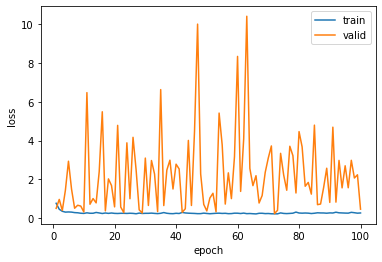

In [69]:
rn50_2_trainer.learning_curve()

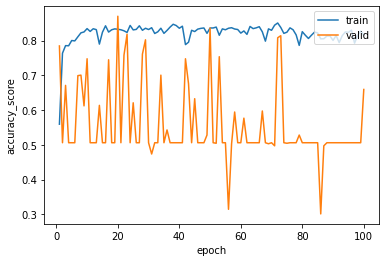

In [70]:
rn50_2_trainer.learning_curve(y='accuracy_score')

In [71]:
sort_epochs(rn50_2_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
39         0.870206   20.0      0.851852        0.892537      0.848397
99         0.836283   50.0      0.761682        0.973134      0.702624
45         0.818584   23.0      0.746512        0.958209      0.682216
145        0.814159   73.0      0.730684        0.988060      0.644315
143        0.808260   72.0      0.727273        0.979104      0.641399
..              ...    ...           ...             ...           ...
173        0.497050   87.0      0.200000        0.005970      0.976676
141        0.497050   71.0      0.000000        0.000000      0.982507
61         0.473451   31.0      0.194444        0.020896      0.915452
111        0.314159   56.0      0.072368        0.032836      0.588921
171        0.300885   86.0      0.160976        0.098507      0.498542

[100 rows x 5 columns]


# resnet 50

In [14]:
rn50 = models.resnet50(pretrained=True)
rn50.conv1 = nn.Conv2d(1, rn50.conv1.out_channels,
              kernel_size=rn50.conv1.kernel_size[0], 
                      stride=rn50.conv1.stride[0], 
                      padding=rn50.conv1.padding[0])
num_ftrs = rn50.fc.in_features
rn50.fc = nn.Linear(num_ftrs, 2)

rn50.post_forward = post_forward

rn50_trainer = trainer(rn50, nn.CrossEntropyLoss(weight=normedWeights), train_loader, valid_loader, test_loader, metrics=metrics, gpu=True)

In [15]:
rn50_trainer.train(100, lr=0.01)

Total:   0%|          | 0/345600 [00:00<?, ?it/s]

  1 26.12s trainloss=0.80016 validloss=4.32967 accuracy_score=0.57817 
  2 5.04s trainloss=0.36922 validloss=0.74070 accuracy_score=0.61062 
  3 4.45s trainloss=0.46084 validloss=1.06627 accuracy_score=0.53097 
  4 4.46s trainloss=0.36899 validloss=0.69051 accuracy_score=0.69322 
  5 4.45s trainloss=0.31750 validloss=0.39368 accuracy_score=0.82891 
  6 4.45s trainloss=0.28748 validloss=2.02431 accuracy_score=0.48525 
  7 4.45s trainloss=0.30121 validloss=0.72993 accuracy_score=0.48525 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  8 4.45s trainloss=0.25907 validloss=6.33491 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  9 4.46s trainloss=0.37839 validloss=22.10227 accuracy_score=0.48230 
 10 4.57s trainloss=0.29787 validloss=1.07585 accuracy_score=0.47640 
 11 4.47s trainloss=0.26766 validloss=0.89313 accuracy_score=0.47640 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 12 4.47s trainloss=0.26978 validloss=3.59884 accuracy_score=0.48230 
 13 4.47s trainloss=0.23012 validloss=3.62256 accuracy_score=0.47935 
 14 4.48s trainloss=0.23651 validloss=3.96863 accuracy_score=0.47935 
 15 4.48s trainloss=0.22000 validloss=1.07883 accuracy_score=0.47788 
 16 4.49s trainloss=0.22831 validloss=3.43160 accuracy_score=0.48083 
 17 4.52s trainloss=0.21346 validloss=0.94595 accuracy_score=0.47640 
 18 4.51s trainloss=0.21729 validloss=1.92201 accuracy_score=0.47935 
 19 4.49s trainloss=0.21895 validloss=0.29497 accuracy_score=0.80531 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 20 4.49s trainloss=0.21653 validloss=6.82484 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 21 4.50s trainloss=0.21129 validloss=12.65225 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 22 4.50s trainloss=0.21153 validloss=5.78213 accuracy_score=0.48230 
 23 4.50s trainloss=0.20831 validloss=7.04762 accuracy_score=0.47935 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 24 4.49s trainloss=0.19565 validloss=8.67175 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 25 4.49s trainloss=0.18925 validloss=13.44152 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 26 4.50s trainloss=0.18675 validloss=11.08576 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 27 4.49s trainloss=0.21068 validloss=13.72866 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 28 4.50s trainloss=0.19294 validloss=14.42535 accuracy_score=0.48230 
 29 4.49s trainloss=0.17735 validloss=0.24839 accuracy_score=0.81858 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 30 4.48s trainloss=0.19416 validloss=13.78665 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 31 4.50s trainloss=0.18064 validloss=16.55139 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 32 4.49s trainloss=0.18188 validloss=8.15262 accuracy_score=0.48230 
 33 4.49s trainloss=0.19772 validloss=0.37148 accuracy_score=0.69617 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 34 4.50s trainloss=0.21818 validloss=7.58552 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 35 4.48s trainloss=0.21160 validloss=10.83710 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 36 4.49s trainloss=0.23995 validloss=4.05385 accuracy_score=0.48230 
 37 4.97s trainloss=0.21225 validloss=0.33987 accuracy_score=0.72419 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 38 4.72s trainloss=0.19285 validloss=6.09418 accuracy_score=0.48230 
 39 4.69s trainloss=0.19139 validloss=11.11719 accuracy_score=0.47935 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 40 4.70s trainloss=0.20340 validloss=10.83915 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 41 4.71s trainloss=0.19847 validloss=2.95760 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 42 4.72s trainloss=0.18419 validloss=16.05172 accuracy_score=0.48230 
 43 4.69s trainloss=0.16451 validloss=9.88766 accuracy_score=0.47935 
 44 4.71s trainloss=0.16489 validloss=0.21055 accuracy_score=0.83628 
 45 4.71s trainloss=0.16671 validloss=13.60330 accuracy_score=0.47935 
 46 4.71s trainloss=0.16645 validloss=11.60375 accuracy_score=0.47935 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 47 4.71s trainloss=0.18733 validloss=8.39658 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 48 4.71s trainloss=0.15813 validloss=18.28936 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 49 4.71s trainloss=0.14776 validloss=18.76668 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 50 4.70s trainloss=0.15491 validloss=19.38082 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 51 4.71s trainloss=0.15195 validloss=20.65239 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 52 4.71s trainloss=0.15520 validloss=13.49863 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 53 4.71s trainloss=0.14768 validloss=8.07365 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 54 4.72s trainloss=0.14349 validloss=15.34653 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 55 4.71s trainloss=0.13433 validloss=19.96195 accuracy_score=0.48230 
 56 4.71s trainloss=0.13606 validloss=3.28587 accuracy_score=0.49115 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 57 4.70s trainloss=0.14009 validloss=16.56783 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 58 4.71s trainloss=0.14078 validloss=14.76755 accuracy_score=0.48230 
 59 4.81s trainloss=0.16231 validloss=7.31017 accuracy_score=0.47935 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 60 4.70s trainloss=0.14128 validloss=13.99160 accuracy_score=0.48230 
 61 4.71s trainloss=0.13441 validloss=16.02996 accuracy_score=0.48083 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 62 4.70s trainloss=0.13359 validloss=12.92864 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 63 4.71s trainloss=0.13440 validloss=13.50419 accuracy_score=0.48230 
 64 4.71s trainloss=0.20680 validloss=2.56955 accuracy_score=0.47493 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 65 4.71s trainloss=0.16253 validloss=9.57129 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 66 4.71s trainloss=0.20123 validloss=6.30535 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 67 4.71s trainloss=0.16988 validloss=12.06113 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 68 4.72s trainloss=0.13721 validloss=11.58201 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 69 4.71s trainloss=0.13087 validloss=12.69569 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 70 4.71s trainloss=0.11547 validloss=15.80185 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 71 4.72s trainloss=0.10882 validloss=12.27400 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 72 4.71s trainloss=0.15009 validloss=13.45101 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 73 4.71s trainloss=0.12369 validloss=10.04963 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 74 4.71s trainloss=0.13037 validloss=14.73534 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 75 4.71s trainloss=0.12931 validloss=16.06539 accuracy_score=0.48230 
 76 4.71s trainloss=0.11163 validloss=18.78947 accuracy_score=0.48083 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 77 4.72s trainloss=0.11823 validloss=13.48426 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 78 4.71s trainloss=0.12320 validloss=12.61068 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 79 4.72s trainloss=0.10202 validloss=23.25560 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 80 4.71s trainloss=0.09993 validloss=16.97058 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 81 4.71s trainloss=0.09800 validloss=15.93137 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 82 4.72s trainloss=0.15335 validloss=15.19425 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 83 4.71s trainloss=0.11317 validloss=15.86249 accuracy_score=0.48230 
 84 4.72s trainloss=0.11009 validloss=0.40135 accuracy_score=0.80973 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85 4.71s trainloss=0.11119 validloss=18.43880 accuracy_score=0.48230 
 86 4.72s trainloss=0.09086 validloss=5.12066 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 87 4.72s trainloss=0.11117 validloss=20.66442 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88 4.71s trainloss=0.11639 validloss=19.81472 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 89 4.72s trainloss=0.10722 validloss=19.57519 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 90 4.72s trainloss=0.09887 validloss=16.63390 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 91 4.72s trainloss=0.08939 validloss=20.02141 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 92 4.72s trainloss=0.09104 validloss=28.39198 accuracy_score=0.48230 
 93 4.72s trainloss=0.10900 validloss=2.94915 accuracy_score=0.50737 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 94 4.71s trainloss=0.09776 validloss=19.72303 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 95 4.72s trainloss=0.11826 validloss=24.55877 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 96 4.71s trainloss=0.09108 validloss=18.03014 accuracy_score=0.48230 
 97 4.71s trainloss=0.11048 validloss=0.78544 accuracy_score=0.50000 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 98 4.71s trainloss=0.09969 validloss=17.79993 accuracy_score=0.48230 


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 99 4.72s trainloss=0.09211 validloss=26.44765 accuracy_score=0.48230 
100 4.71s trainloss=0.10051 validloss=0.39457 accuracy_score=0.77876 


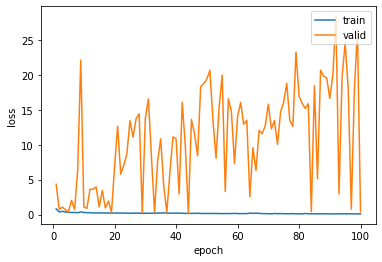

In [16]:
rn50_trainer.learning_curve()

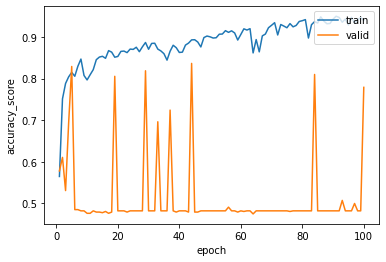

In [17]:
rn50_trainer.learning_curve(y='accuracy_score')

In [18]:
sort_epochs(rn50_trainer.evaluator, 'accuracy_score')

     accuracy_score  epoch  prec_chewing  recall_chewing  recall_other
87         0.836283   44.0      0.759740        1.000000      0.660550
9          0.828909    5.0      0.800512        0.891738      0.761468
57         0.818584   29.0      0.745690        0.985755      0.639144
167        0.809735   84.0      0.738197        0.980057      0.626911
37         0.805310   19.0      0.733475        0.980057      0.617737
..              ...    ...           ...             ...           ...
29         0.477876   15.0      0.000000        0.000000      0.990826
19         0.476401   10.0      0.000000        0.000000      0.987768
21         0.476401   11.0      0.000000        0.000000      0.987768
33         0.476401   17.0      0.250000        0.005698      0.981651
127        0.474926   64.0      0.000000        0.000000      0.984709

[100 rows x 5 columns]


# End notebook

In [ ]:
%%javascript
Jupyter.notebook.session.delete();